# Introduction to scETM

In this introductory tutorial, we will analyze a published mouse pancreas islet dataset (GSE84133) using scETM.

### Prepare data

scETM uses AnnData objects from the anndata package to represent single-cell datasets. AnnData is a versatile format compatible with multiple single-cell frameworks, e.g. scanpy and scvi-tools.

In [11]:
# Download and decompress the data
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2230761&format=file&file=GSM2230761_mouse1_umifm_counts.csv.gz' -O GSM2230761_mouse1_umifm_counts.csv.gz
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM2230762&format=file&file=GSM2230762_mouse2_umifm_counts.csv.gz' -O GSM2230762_mouse2_umifm_counts.csv.gz
!gzip -d GSM2230761_mouse1_umifm_counts.csv.gz
!gzip -d GSM2230762_mouse2_umifm_counts.csv.gz

In [1]:
import anndata as ad
import pandas as pd
csvs = ['GSM2230761_mouse1_umifm_counts.csv', 'GSM2230762_mouse2_umifm_counts.csv']
adatas = []
for fpath in csvs:
    df = pd.read_csv(fpath, index_col=0)
    adata = ad.AnnData(X=df.iloc[:, 2:], obs=df.iloc[:, :2])
    adatas.append(adata)
adata = ad.concat(adatas, label="batch_indices")
adata

AnnData object with n_obs × n_vars = 1886 × 14878
    obs: 'barcode', 'assigned_cluster', 'batch_indices'

Note that the cell type information is in the "assigned_cluster" column, and the batch information is in the "batch_indices" column. The column names will be useful when we train and evaluate the model, so keep them in mind!

### Train scETM

We then instantiate an scETM model, and use an UnsupervisedTrainer to train it.

Note that scETM requires about 6k steps to converge (observe the test NLL to confirm that), so for this datasets whose size is smaller than the training minibatch size (which means training for an epoch requires only one training step), it is recommended to train for at least 6k epochs.

In [2]:
from scETM import scETM, UnsupervisedTrainer, evaluate
import scanpy as sc
sc.set_figure_params(dpi=120, dpi_save=250, fontsize=10, figsize=(10, 10), facecolor="white")

model = scETM(adata.n_vars, adata.obs.batch_indices.nunique())
trainer = UnsupervisedTrainer(model, adata, test_ratio=0.1)

trainer.train(n_epochs = 12000, eval_every = 1000, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

ts=1907038, peak_wset=3515269120, wset=3291279360, peak_paged_pool=5310376, paged_pool=5309896, peak_nonpaged_pool=1260752, nonpaged_pool=280432, pagefile=8686792704, peak_pagefile=8911253504, private=8686792704)
[2021-04-20 03:09:20,725] INFO - scETM.trainer: lr          : 0.0034883816303552992
[2021-04-20 03:09:20,726] INFO - scETM.trainer: kl_weight   :       0.0000
[2021-04-20 03:09:20,727] INFO - scETM.trainer: loss        :       6.5946
[2021-04-20 03:09:20,727] INFO - scETM.trainer: nll         :       6.5946
[2021-04-20 03:09:20,728] INFO - scETM.trainer: kl_delta    :     276.6905
[2021-04-20 03:09:20,728] INFO - scETM.trainer: max_norm    :       0.0912
[2021-04-20 03:09:20,747] INFO - scETM.trainer: test nll:  6.7158
[2021-04-20 03:09:20,869] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 1886 × 14878
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0

### Get scETM output embeddings

The gene and trainale topic embeddings are stored in `model.alpha` and `model.rho_trainable`, respectively.

The cell embeddings are not stored in the model since we use amortised inference. Instead, they can be inferred from the encoder of the model using `model.get_embeddings_and_nll(adata)`. After calling this function, you can find the cell embeddings in `adata.obs['delta']`.

In [ ]:
model.get_embeddings_and_nll(adata)

### Evaluate scETM

As you can see in the training log, evaluation metrics are already printed every `eval_every` epochs. To explicitly evaluate the model, use the `evaluate` function provided by scETM.

The `evaluate` function looks for the `embedding_key` (which defaults to "delta") in adata.obsm, evaluates its ARI with cell type and batch, NMI with cell type, batch mixing entropy and kBET, then plots the embedding. Use `return_fig=True` to get the plotted figure, or specify `plot_dir` to save the figure to a file.

Note that we specify the `cell_type_col` and the `batch_col` arguments to let scETM find our cell type annotation and batch information for each cell.

[2021-04-20 03:35:09,256] INFO - scETM.logging_utils: evaluate(AnnData object with n_obs × n_vars = 1886 × 14878
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'leiden_0.06', 'leiden_0.08', 'leiden_0.1', 'leiden_0.13'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_0.06_colors', 'batch_indices_colors', 'assigned_cluster_colors'
    obsm: 'delta', 'theta', 'recon_log', 'X_umap'
    obsp: 'distances', 'connectivities', resolutions = [0.06, 0.08, 0.1, 0.13], return_fig = True, cell_type_col = assigned_cluster)
[2021-04-20 03:35:09,402] INFO - scETM.eval_utils: Performing leiden clustering
[2021-04-20 03:35:09,556] INFO - scETM.eval_utils: Resolution:  0.06	ARI:  0.8450	NMI:  0.7916	bARI:  0.0675	# labels: 4
[2021-04-20 03:35:09,734] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.8450	NMI:  0.7916	bARI:  0.0675	# labels: 4
[2021-04-20 03:35:09,896] INFO - scETM.eval_utils: Resolution:   0.1	ARI:  0.7689	NMI:  0.7659	bARI:  0.0880	# labels: 6
[2021-04-20 03:35:10,077] INFO - s

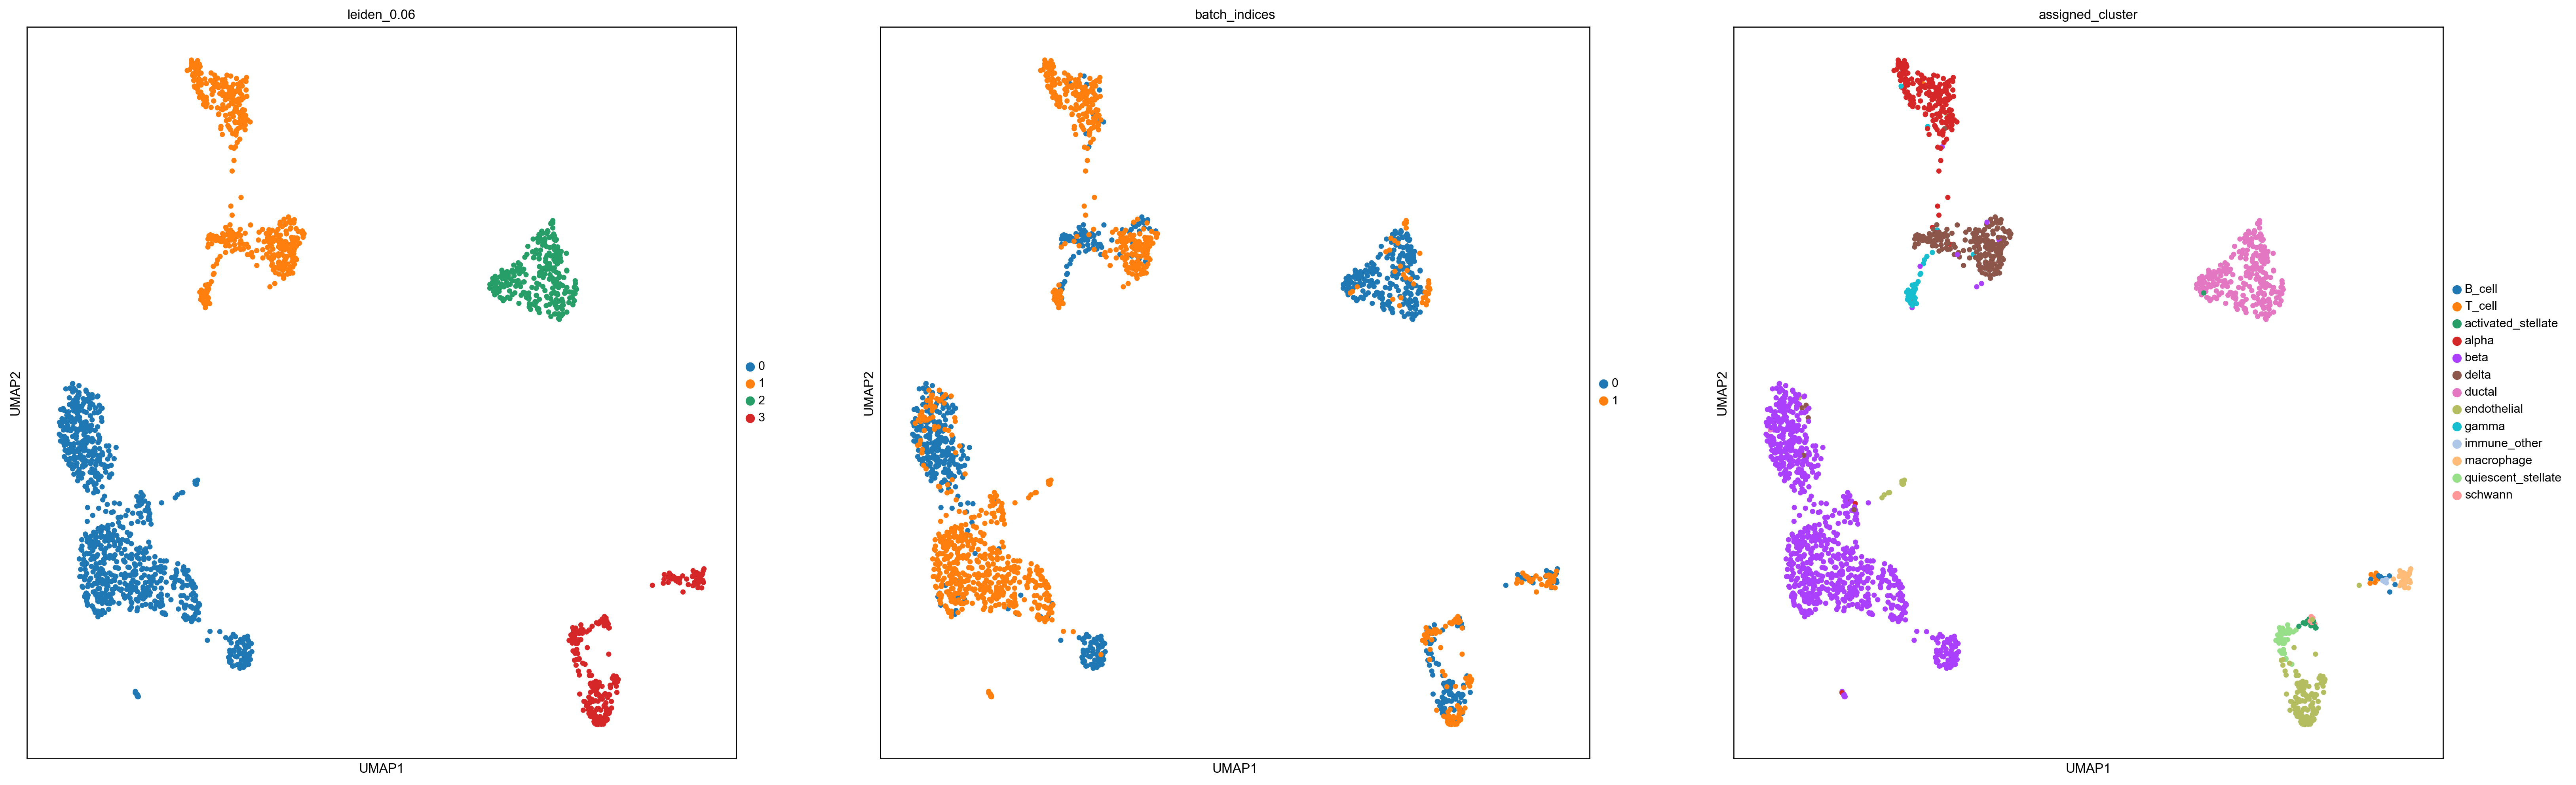

In [6]:
result = evaluate(adata, resolutions = [0.06, 0.08, 0.1, 0.13], return_fig=True, cell_type_col="assigned_cluster", batch_col="batch_indices")